In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Amazon Fine Food Reviews Analysis using Logistic Regression.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

#### Basic information about the downloaded dataset<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.
In this problem we will apply classification techniques called Logistic Regression to get an idea if the data can be seperated based on its polarity, i.e. if the review is positive or negative. By looking at the Score column we can make out that the review is positive or not. But we don't need to implement any ML here. A simple if-else condition will make us do this. So for this problem, we will put our focus on to the Review text. The text is the most important feature here if you may ask. Based on the review text we will build a prediction model and determine if a future review is positive or negative.

#### While pre-processing the original dataset we have taken into consideration the following points.

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 4 or 5.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 1 or 2.
3. We will ignore the reviews for the time being which has a Score rating of 3. Because 3 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset. 
5. We will train our final mdel using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
6. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative (Determining the sentiment polarity of the Amazon reviews)

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from datetime import datetime as dt

In [3]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('database.sqlite') 

#Filter only positive and negative reviews. Do not consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display some of the datapoints from the loaded dataset.
print("Number of data points in our data", filtered_data.shape[0])
print("Number of features in our data", filtered_data.shape[1])
filtered_data.head(5)

Number of data points in our data 525814
Number of features in our data 12


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
#This code block check how many entries are there from the same user id, who has provided review more than one time for different products.
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", connection_sqlobject)

print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

In [7]:
#Checking the number of entries that came from UserId="AR5J8UI46CURR"
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", connection_sqlobject)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to Time in ascending order. The oldest reviews will be displayed at the top and the new reviews will be display at the end of the dataset.
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Removing duplicate entries based on past knowledge.
filtered_duplicates=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print("The shape of the data matrix after deduplication, Stage 1: {}".format(filtered_duplicates.shape))

The shape of the data matrix after deduplication, Stage 1: (364173, 12)


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calculations

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", connection_sqlobject)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

In [13]:
#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication, Stage 2: : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Delete unwanted variables to free up memory space
del(filtered_duplicates, filtered_data, display, sorted_data)

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)


The shape of the data matrix after deduplication, Stage 2: : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
122486,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1
435165,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0
279857,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1
279856,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1
466254,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1


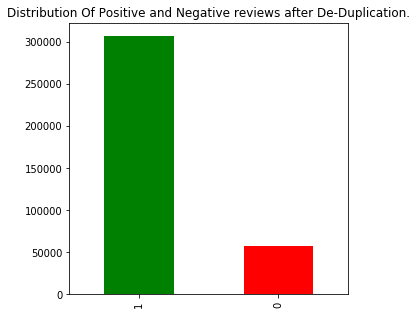

In [14]:
#Display distribution of Postive and Negative reviews in a bar graph
final_data["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
#Printing some random reviews from the deduplicated dataset.
sent_1 = final_data['Text'].values[0]
print(sent_1)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[0]))
print("="*215)

sent_2 = final_data['Text'].values[1000]
print(sent_2)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1000]))
print("="*215)

sent_3 = final_data['Text'].values[1500]
print(sent_3)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[1500]))
print("="*215)

sent_4 = final_data['Text'].values[4900]
print(sent_4)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[4900]))
print("="*215)

sent_5 = final_data['Text'].values[12566]
print(sent_5)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[12566]))
print("="*215)

sent_6 = final_data['Text'].values[255600]
print(sent_6)
print("Review Polarity: {}".format(final_data['SentimentPolarity'].values[255600]))
print("="*215)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.
Review Polarity: Positive
I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.
Review Polarity: Positive
This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.<br /><br />Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again.
Review Polarity: Positive
At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My d

In [16]:
#Remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_1 = re.sub(r"http\S+", " ", sent_1)
sent_2 = re.sub(r"http\S+", " ", sent_2)
sent_3 = re.sub(r"http\S+", " ", sent_3)
sent_4 = re.sub(r"http\S+", " ", sent_4)
sent_5 = re.sub(r"http\S+", " ", sent_5)
sent_6 = re.sub(r"http\S+", " ", sent_6)

print(sent_1,"\n")
print("="*215)
print(sent_2,"\n")
print("="*215)
print(sent_3,"\n")
print("="*215)
print(sent_4,"\n")
print("="*215)
print(sent_5,"\n")
print("="*215)
print(sent_6,"\n")
print("="*215)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful. 

I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal. 

This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.<br /><br />Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again. 

At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My daughter also had the same results. 

Excellent service, the product arri

In [17]:
#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text


print(removeHtml(sent_1) + "\n")
print(removeHtml(sent_2) + "\n")
print(removeHtml(sent_3) + "\n")
print(removeHtml(sent_4) + "\n")
print(removeHtml(sent_5) + "\n")
print(removeHtml(sent_6) + "\n")

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.

I was concerned about the what the expiration dates might be on these canned items, but they were good until 2015. This is a good deal.

This is my first time trying coconut oil.  I was happy that the oil has a very mild flavor.  I did try cooking with it by adding some to butter when cooking eggs.  I didn't taste any coconut, so I was happy with that.  Overall, it is a good product because it didn't have a strong taste and I will be purchasing it again.

At first I too loved this shampoo. After only 2 weeks (washing 3 times a week) my hair started falling out in huge amounts. I quit using it and after a month there seems to be less fall out. My once thick native hair is now weak and thin. My daughter also had the same results.

Excellent service, the product arrived on time an

In [18]:
# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
import re

#Expand the reviews x is aninput string of any length. Convert all the words to lower case
def decontracted(x):
    x = str(x).lower()
    x = x.replace(",000,000", " m").replace(",000", " k").replace("′", "'").replace("’", "'")\
                           .replace("won't", " will not").replace("cannot", " can not").replace("can't", " can not")\
                           .replace("n't", " not").replace("what's", " what is").replace("it's", " it is")\
                           .replace("'ve", " have").replace("'m", " am").replace("'re", " are")\
                           .replace("he's", " he is").replace("she's", " she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("how's"," how has").replace("y'all"," you all")\
                           .replace("o'clock"," of the clock").replace("ne'er"," never").replace("let's"," let us")\
                           .replace("finna"," fixing to").replace("gonna"," going to").replace("gimme"," give me").replace("gotta"," got to").replace("'d"," would")\
                           .replace("daresn't"," dare not").replace("dasn't"," dare not").replace("e'er"," ever").replace("everyone's"," everyone is")\
                           .replace("'cause'"," because")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    return x

In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
'''
>>> import re
>>> s = "ABCD abcd AB55 55CD A55D 5555"
>>> re.sub("\S*\d\S*", "", s).strip()

'ABCD abcd'
>>>'''

sent_1 = re.sub("\S*\d\S*", " ", sent_1).strip()
print(sent_1)

The Premium Bourbon Madagascar Vanilla Vannila Beans were exactly as described in the ad.  They arrived promptly and I have made my first batch of homemade French Vanilla Creamer with them.  They are wonderful.


In [20]:
'''Data Cleaning Stage. Clean each review from the sampled Amazon Dataset.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

''' pattern = re.compile('<.*?>') #Function to clean html tags from a sentence
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text'''

#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return (sentence)

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return (sentence)
    
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return (cleaned_text)

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    cleaned_text  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return (cleaned_text)

In [22]:
#Stemming and stopwords removal
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

<h2><font color='red'>[3.1] Preprocessing Review Text</font></h2>

100%|████████████████████████████████████████████████████████████████████████| 70246/70246 [00:00<00:00, 395918.01it/s]


Text(0, 0.5, 'Number of Words')

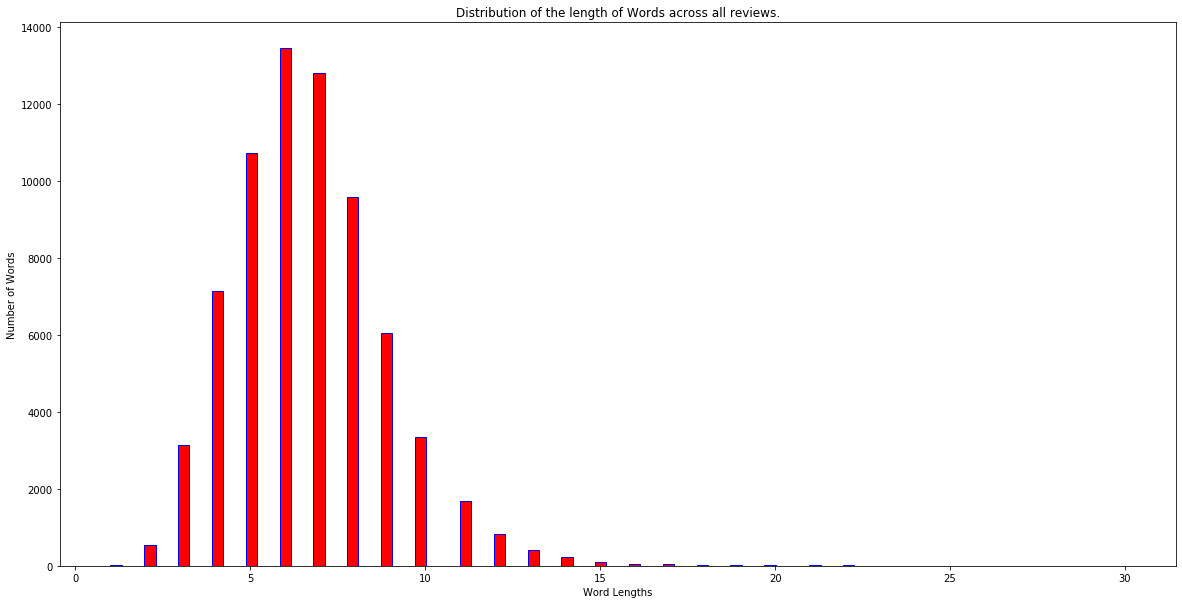

In [23]:
#We will check the distribution of stemmed word lengths across the whole review dataset to understand what is the length of the maximum number of words we will consider for the word to be relevant.
#In other words we will keep only those words which has a length less than that of a speicific length (we will obtain this specific length from the histogram).
total_words = []

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords)):          
            stemed_word=(sno.stem(cleaned_words.lower()))
            total_words.append(stemed_word)

total_words = list(set(total_words)) #Get list of unique words.

#A list to hold the length of each words used in all the reviews used across the whole dataset.
dist = []
for i in tqdm(total_words):
    length = len(i)
    dist.append(length)

# matplotlib histogram to see the distribution of the length of words
plt.figure(figsize=(20,10))
plt.hist(dist, color = 'red', edgecolor = 'blue', bins =90)
plt.title('Distribution of the length of Words across all reviews.')
plt.xlabel('Word Lengths')
plt.ylabel('Number of Words')

### Conclusion from the above histogram:
We can see that most stemmed words present in the reviews has lengths between 4 and 10. Words which has length greater than 15 are very very very few as compared to other words. So we will discard these words from the reviews when we process them. It means we will consider only those words whose length is greater than 2 and less than 16.

In [24]:
# Combining all the above data cleaning methodologies as discussed above.

#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
 
count=0     #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
stemed_word=' '

for review in tqdm(final_data['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            stemed_word=(sno.stem(cleaned_words.lower()))                                   
            filtered_sentence.append(stemed_word)
            if (final_data['SentimentPolarity'].values)[count] == 'Positive': 
                all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
            if(final_data['SentimentPolarity'].values)[count] == 'Negative':
                all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
        else:
            continue
    review = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_reviews.append(review.strip()) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
#Save the list of positive words and negative words
import pickle
with open('all_positive_words.pkl', 'wb') as file:
    pickle.dump(all_positive_words, file)
    
with open('all_negative_words.pkl', 'wb') as file:
    pickle.dump(all_negative_words, file)
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
final_data['CleanedText']=preprocessed_reviews

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [17:03<00:00, 355.67it/s]


The length of the data corpus is : 364171


<h2><font color='red'>[3.2] Preprocessing Review Summary + Saving the Processed DB for future use.</font></h2>

In [25]:
## Similartly you can do preprocessing for summary summary also.
import warnings
warnings.filterwarnings("ignore")

preprocessed_summary = [] #Store all the processed summary
 
count=0     #Iterator to iterate through the list of summarys and check if a given summary belongs to the positive or negative class
string=' '    
stemed_word=' '

for summary in tqdm(final_data['Summary'].values):
    filtered_sentence=[]
    summary = decontracted(summary)
    summary = removeNumbers(summary)
    summary = removeHtml(summary)
    summary = removeURL(summary)
    summary = removePunctuations(summary)
    summary = removePatterns(summary)
    
    for cleaned_words in summary.split():
        if(2<len(cleaned_words)<16):
            stemed_word=(sno.stem(cleaned_words.lower()))
            filtered_sentence.append(stemed_word)
    summary = " ".join(filtered_sentence) #Final string of cleaned words    
    preprocessed_summary.append(summary.strip()) #Data corpus contaning cleaned summarys from the whole dataset
    count+=1
    
#Adding a column of CleanedSummary to the table final which stores the data_corpus after pre-processing the summarys 
final_data['CleanedSummary']=preprocessed_summary

#Combing the reviews with summary for each sentence
final_data['Combined_Reviews'] = final_data['CleanedText'].values + " " + final_data['CleanedSummary'].values 

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
final_data.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True)

print("File is saved as 'totally_processed_DB.sqlite'")

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:18<00:00, 4649.80it/s]


File is saved as 'totally_processed_DB.sqlite'


# [4] Featurization

In [26]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite') 
processed_db = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data into train and test set. The train set will contain 100K old reviews. The test set has 30k newer reviews. We will also use 40K latest reviews as a calibration dataset to calibrate our model. 
X_train = processed_db['CleanedText'].iloc[150000:250000,] ; y_train = processed_db['Class_Labels'].iloc[150000:250000,]
X_test = processed_db['CleanedText'].iloc[250000:280000,] ; y_test = processed_db['Class_Labels'].iloc[250000:280000,]
X_calib = processed_db['CleanedText'].iloc[280000:320000,] ; y_calib = processed_db['Class_Labels'].iloc[280000:320000,]

processed_db.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels,CleanedText,CleanedSummary,Combined_Reviews
0,122486,132756,B000O3KMKG,AAB6ZMWFCK4GO,Bill Gary,0,0,5,1351209600,Excellent,The Premium Bourbon Madagascar Vanilla Vannila...,Positive,1,premium bourbon madagascar vanilla vannila bea...,excel,premium bourbon madagascar vanilla vannila bea...
1,435165,470583,B001LUM1ZU,A3HJN5HU71FQIT,muxicboxsuprhero,0,0,1,1351209600,God Awful,As a dabbler who enjoys spanning the entire sp...,Negative,0,dabbler enjoy span entir spectrum tast will tr...,god aw,dabbler enjoy span entir spectrum tast will tr...
2,279857,303246,B0002DGRZC,AUINI96NMGXUI,Kkrys23,0,0,5,1351209600,Love this faucet,Love this faucet. My husband had installed th...,Positive,1,love faucet husband instal one old hous curren...,love this faucet,love faucet husband instal one old hous curren...
3,279856,303245,B0002DGRZC,A3SSEJ8IEM4YGW,Seagaul,0,0,5,1351209600,Dogs love it.,"This is the ""all gone"" treat after dinner. It...",Positive,1,gone treat dinner treat dog work run chanc los...,dog love,gone treat dinner treat dog work run chanc los...
4,466254,504114,B001M0AKE8,A07112861KSNE1D0ZA1NO,Canon Fan,0,0,4,1351209600,Quaker Instant Oatmeal Dinosaur Eggs,This has been a firm favorite at breakfast tim...,Positive,1,firm favorit breakfast time hous mani year pic...,quaker instant oatmeal dinosaur egg,firm favorit breakfast time hous mani year pic...


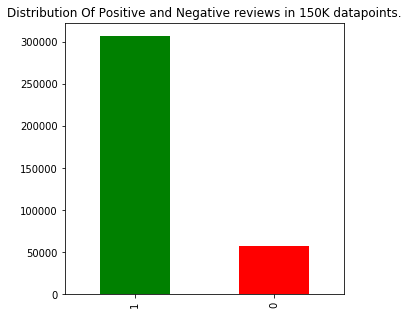

In [27]:
#Display distribution of Postive and Negative reviews in a bar graph
processed_db["Class_Labels"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews in 150K datapoints.',figsize=(5,5))

## [4.1] BAG OF WORDS

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling, such as with machine learning algorithms.
The approach is very simple and flexible, and can be used in a myriad of ways for extracting features from documents. Suppose we have N reviews in our dataset and we want to convert the words in our reviews to vectors. We can use BOW as a method to do this. What it does is that for each unique word in the data corpus, it creates a dimension. Then it counts how many number of times a word is present in a review. And then this number is placed under that word for a corresponding review. We will get a Sparse Matrix representation for all the worods inthe review.

Let's look at this example of 2 reviews below :

r1 = {"The food is great, ambience is great"} and  </br>r2 = {"I love this food"}

At first the words will be extracted from r1 and r2.

r1' = {"The", "food", "is", "great", "ambience", "is", "great"} and r2' = {"I", "love", "this", "food"}

Now using r1' and r2' we will create a vector of unique words -> V =  {"The", "food", "is", "great", "ambience", "I", "love", "this"}

Now here's how the vector representation will look like for each reviews r1 and r2, when we make use of the vector 'V' created above.

r1_vector = [1,1,2,2,1,0,0,0] and r2_vector = [0,1,0,0,0,1,1,1]

In r1 since, "great" and "is" occurs twice, we have set the count to 2. If a words doesn't occur in a review we will set the count to 0. Although "is" a stopword, the example above is intended to make you understand how bag of words work.



In [28]:
#Initializing the BOW constructor
cv_object = CountVectorizer(min_df=10, max_features=50000, dtype='float')
cv_object.fit(X_train)

#Print names of some random features
print("Some feature names ", cv_object.get_feature_names()[100:110])
print('='*215)

#Creating the BOW matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus...")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)
X_calib_vectors = cv_object.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BOW vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BOW vectorizer ",X_test_vectors.get_shape())
print("The number of unique words ", X_train_vectors.get_shape()[1])

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_BOW.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)

with open('y_train_BOW.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('X_test_BOW.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_test_BOW.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_BOW.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_BOW.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['afford', 'afghanistan', 'aficionado', 'aforement', 'afraid', 'africa', 'african', 'afteral', 'afternoon', 'aftertast']

Creating the BOW vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BOW vectorizer  (100000, 8461)
The shape of our test BOW vectorizer  (30000, 8461)
The number of unique words  8461


## [4.2] Bi-Grams and n-Grams.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

#Initializing the Bi-Gram constructor
cv_object = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=50000, dtype='float')             #min_df=10: ignore terms that have a document frequency strictly lower than 10.
cv_object.fit(X_train)                                                                                  #max_features=50000: top 50000 features

#Print names of some random features
print("Some feature names ", cv_object.get_feature_names()[100:110])
print('='*215)

#Creating the Bi-Gram matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the Bi-Gram vectors using the cleaned corpus...")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BiGram vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BiGram vectorizer ",X_test_vectors.get_shape())
print("The number of unique words ", X_train_vectors.get_shape()[1])

#Save the bi grams train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_BiGrm.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)

with open('y_train_BiGrm.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('X_test_BiGrm.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_test_BiGrm.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_BiGrm.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_BiGrm.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['accommod', 'accompani', 'accomplish', 'accord', 'accord box', 'accord direct', 'accord instruct', 'accord label', 'accord packag', 'accord tast']

Creating the Bi-Gram vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BiGram vectorizer  (100000, 50000)
The shape of our test BiGram vectorizer  (30000, 50000)
The number of unique words  50000


## [4.3] TF-IDF

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

Let's assume we have data corpus D, which contains N reviews {r1,r2,r3,r4...rN}. Let's say our review r1 contains the following words {w1,w2,w3,w1,w9,w6,w7,w9,w9}.

TF or Term Frequency for a word is basically the number of times a word occurs in a review divided by the total number of words present in that same review.
For example, in the text corpus that we have considered in the above example, the TF for word w1 is (2/9) and for word w9 is (1/3). Intuitively, higher the occurence of a word in a text is, greater will be its TF value. TF values lies between 0 and 1.

IDF or Inverse Document Frequency for a word is given by the formula log(N/n), where 'N' is equal to the total number of reviews in the corpus 'D' and 'n' refers to the number of reviews in 'D' which contains that specific word. Intuitively, IDF will be higher for words which occur rarely and will be less for words which occurs more frequently. IDF values are more than 0.

So for each word in each review we will consider the product of (TF x IDF), and represent it in a d dimensional vector. 

TF-IDF basically doesn't consider the semantic meaning of words. But what is does is that it gives more importance to words which occurs less frequently in the whole data corpus and also gives much importance to the most frequent words that occurs in each review.

In [30]:
#Initializing the TF-IDF constructor
tf_idf_obj = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=50000, dtype='float').fit(X_train) #min_df=10: ignore terms that have a document frequency strictly lower than 10.
                                                                                                           #max_features=50000: top 50000 features
#Print names of some random features
print("Some feature names ", tf_idf_obj.get_feature_names()[100:110])
print('='*215)

#Creating the TF-IDF matrix from cleaned data corpus. Only 'not', 'no', 'nor' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the TF-IDF vectors using the cleaned corpus...")
X_train_vectors = tf_idf_obj.transform(X_train)
X_test_vectors = tf_idf_obj.transform(X_test)
X_calib_vectors = tf_idf_obj.transform(X_calib)

print("\nThe type of count vectorizer ",type(X_train_vectors))
print("The shape of our train BiGram vectorizer ",X_train_vectors.get_shape())
print("The shape of our test BiGram vectorizer ",X_test_vectors.get_shape())
print("The number of unique words including both unigrams and bigrams. ", X_train_vectors.get_shape()[1])

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

Some feature names  ['accommod', 'accompani', 'accomplish', 'accord', 'accord box', 'accord direct', 'accord instruct', 'accord label', 'accord packag', 'accord tast']

Creating the TF-IDF vectors using the cleaned corpus...

The type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
The shape of our train BiGram vectorizer  (100000, 50000)
The shape of our test BiGram vectorizer  (30000, 50000)
The number of unique words including both unigrams and bigrams.  50000


## [4.4] Word2Vec

In [31]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in processed_db['CleanedText'].values:
    list_of_sentance.append(sentance.split())

In [32]:
# Using Google News Word2Vectors

# In this project we are using a pretrained model by google. Its a 3.3G file, once you load this into your memory it occupies ~9Gb, so please do this step only if you have >12G of ram. We will provide a pickle 
# file wich contains a dict , and it contains all our courpus words as keys and  model[word] as values. To use this code-snippet, download "GoogleNews-vectors-negative300.bin" from 
# https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit. It's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = False

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*215)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
        
'''
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
'''

'\nw2v_words = list(w2v_model.wv.vocab)\nprint("number of words that occured minimum 5 times ",len(w2v_words))\nprint("sample words ", w2v_words[0:50])\n'

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2V

In this model we convert each word present in a review to vectors. For each sentence we will compute the average word to vec representation. Let's look at the below demo example.

Suppose we have N words in a sentence {w1,w2,w3,w4,w5,w6 ... , wN}. We will convert each word to a vector, sum them up and divide by the total number of words (N) present in that particular sentence. So our final vector will look like (1/N) * [word2vec(w1) + word2vec(w2) + word2vec(w3) .... + word2vec(wN)]

In [33]:
#Build a Word2Vec model on train data and use this to vectorize the test and cv data.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split()) #Returns a list of words for each sentence for all the reviews
print("The size of the Word2Vec text corpus : ",len(word2vec_corpus))

word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=6) #min_count = 5 considers only those words for our model which occurs atleast 5 times
word2vec_words = list(word2vec_model.wv.vocab)                                       #print("\nThe number of words that occured minimum 5 times : ",len(word2vec_words))

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_w2v(dataset, word2vec_model, word2vec_words):
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split()) 
    
    # Creating average Word2Vec model by computing the average word2vec for each review.
    sent_vectors = []; #The average word2vec for each sentence/review will be stored in this list
    for sentence in tqdm(word2vec_corpus): #For each review
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        count_words =0; #This will store the count of the words with a valid vector in each review text
        for word in sentence: #For each word in a given review.
            if word in word2vec_words:
                word_vectors = word2vec_model.wv[word] #Creating a vector(numpy array of 100 dimensions) for each word.
                sent_vec += word_vectors
                count_words += 1
        if count_words != 0:
            sent_vec /= count_words
        sent_vectors.append(sent_vec)
    #print("\nThe length of the sentence vectors :",len(sent_vectors))
    #print("\nSize of each vector : ",len(sent_vectors[0]))
    sent_vectors = np.array(sent_vectors)
    return sent_vectors


X_train_vectors = vectorize_w2v(X_train, word2vec_model, word2vec_words)
X_test_vectors = vectorize_w2v(X_test, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_w2v(X_calib, word2vec_model, word2vec_words)


print("The shape of our Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)

#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_W2V.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_W2V.pkl', 'wb') as file:
    pickle.dump(y_test, file)

with open('X_calib_W2V.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_W2V.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

The size of the Word2Vec text corpus :  100000


100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [01:33<00:00, 429.55it/s]


The shape of our Avg Word2Vec train vectorizer  (100000, 200)
The shape of our Avg Word2Vec test vectorizer  (30000, 200)
The shape of our Avg Word2Vec calibration vectorizer  (40000, 200)


#### [4.4.1.2] TFIDF weighted W2v

In this model we convert each word present in a review to vectors. For each sentence we will compute the tf-idf average word to vec representation. Let's look at the below demo example.

Suppose we have N words in a sentence {w1,w2,w3,w4,w5,w6 ... , wN}. We will compute the tf-idf for each word in a review for all reviews. Lets say the corresponding tf-idfs are {t1,t2,t3,t4,t5,t6......tN}. We will convert each word to a vector, sum them up and divide by the summation of tf-idf vectors for all words present in that particular sentence. So our final vector will look like [1/(t1+t2+t3+t4+t5+t6+ ..... +tN)] * [word2vec(w1) + word2vec(w2) + word2vec(w3) .... + word2vec(wN)]

In [34]:
#Build a word2vec model using the train data and use this model to vectorize test and cv data.
#word2vec_corpus will store the list of words for each review.
word2vec_corpus=[]
for sentence in X_train:
    word2vec_corpus.append(sentence.split())

#min_count = 5 considers only those words which occurs atleast 5 times
word2vec_model=Word2Vec(sentences=word2vec_corpus, size=200, min_count=5, workers=8)
word2vec_words = list(word2vec_model.wv.vocab)

#Initializing the TF-IDF contructor with review texts. HTML tags and punctuations are removed. Stopwords are preserved.
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#This method returns the Average Word2Vec vectors for all reviews in a given dataset
def vectorize_tfidf_w2v(dataset, tf_idf_object, word2vec_model, word2vec_words):

    #word2vec_corpus will store the list of words for each review.
    word2vec_corpus=[]
    for sentence in dataset:
        word2vec_corpus.append(sentence.split())

    #Use the earlier TF-IDF object to vectorize test and cv data.
    tf_idf_matrix = tf_idf_object.transform(dataset)
    tfidf_features = tf_idf_object.get_feature_names() 
    
    # We are building a dictionary with words as a key, and the idfs as value
    dictionary = dict(zip(tf_idf_object.get_feature_names(), list(tf_idf_object.idf_)))

    #Algorithm for finding the TF-IDF weighted average word2vec vectors.
    tfidf_sent_vectors = []; #The tfidf-w2v for each sentence/review will stored in this list
    row=0;
    for sentence in tqdm(word2vec_corpus): #For each review/sentence 
        sent_vec = np.zeros(200) #200 dimensional array, where all elements are zero. This is used to add word vectors and find the averages at each iteration.
        weight_sum = 0; #This will store the count of the words with a valid vector in each review text.
        for word in sentence: #For each word in a review/sentence
            if((word in word2vec_words) and (word in tfidf_features)):
                word_vectors = word2vec_model.wv[word]
                tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) #tf_idf = tf_idf_matrix[row, tfidf_features.index(word)] #tf_idfidf of a word in a sentence/review       
                sent_vec += (word_vectors * tf_idf)                            #dictionary[word] = idf value of word in whole courpus  # sent.count(word) = tf valeus of word in this review                          
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1

    tfidf_sent_vectors = np.array(tfidf_sent_vectors)
    return tfidf_sent_vectors

#Converting the words to word vector representation.
X_train_vectors = vectorize_tfidf_w2v(X_train, tf_idf_object, word2vec_model, word2vec_words)
X_test_vectors = vectorize_tfidf_w2v(X_test, tf_idf_object, word2vec_model, word2vec_words)
X_calib_vectors = vectorize_tfidf_w2v(X_calib, tf_idf_object, word2vec_model, word2vec_words)

print("The shape of our TF-IDF Avg Word2Vec train vectorizer ",X_train_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec test vectorizer ",X_test_vectors.shape)
print("The shape of our TF-IDF Avg Word2Vec calibration vectorizer ",X_calib_vectors.shape)
                                           
#Save the bow train and test matrices for later use. We will need this later when we apply our models on them
import pickle
with open('X_train_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_train_vectors, file)
    
with open('X_test_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_test_vectors, file)
    
with open('y_train_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_train, file)
    
with open('y_test_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_test, file)
    
with open('X_calib_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(X_calib_vectors, file)
    
with open('y_calib_TFIDF-W2V.pkl', 'wb') as file:
    pickle.dump(y_calib, file)

100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [24:38<00:00, 27.05it/s]


The shape of our TF-IDF Avg Word2Vec train vectorizer  (100000, 200)
The shape of our TF-IDF Avg Word2Vec test vectorizer  (30000, 200)
The shape of our TF-IDF Avg Word2Vec calibration vectorizer  (40000, 200)


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

In [35]:
#This function is used to standardize a data matrix.
def standardize(data, with_mean):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=with_mean)
    std=scalar.fit_transform(data)
    return (std)

#This function is used to get the top features for each of the model for each of the featurizations.
def top_features(best_estimator, X_train_standardized, y_train, vectorizer_object):
    '''Get the most important features for the given input vector.'''
    lr_model = best_estimator
    lr_model.fit(X_train_standardized, y_train)
    top_pos_features = (-lr_model.coef_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    top_neg_features = (lr_model.coef_[0, :]).argsort()  
    top_pos_features = np.take(vectorizer_object.get_feature_names(), top_pos_features[:75])
    top_neg_features = np.take(vectorizer_object.get_feature_names(), top_neg_features[:75])
    
    weight_vector = lr_model.coef_
    return (weight_vector, top_pos_features, top_neg_features)

#This function is used to plot the ROC curve on both train and test.
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def plot_roc(classifier, X_train, y_train, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    '''TEST DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    fpr["Test"], tpr["Test"], threshold = roc_curve(y_test, y_probs)
    roc_auc["Test"] = auc(fpr["Test"], tpr["Test"])
    
    '''TRAIN DATA ROC CURVE'''
    #Use probability scores to compute the ROC Curve
    class_probabilities = classifier.predict_proba(X_train)
    y_probs = class_probabilities[:,1]
    fpr["Train"], tpr["Train"], threshold = roc_curve(y_train, y_probs)
    roc_auc["Train"] = auc(fpr["Train"], tpr["Train"])
    
    plt.figure(figsize=(15,10))
    linewidth = 2
    plt.plot(fpr["Test"], tpr["Test"], color='green', lw=linewidth, label='ROC curve Test Data (area = %0.2f)' % roc_auc["Test"])
    plt.plot(fpr["Train"], tpr["Train"], color='red', lw=linewidth, label='ROC curve Train Data (area = %0.2f)' % roc_auc["Train"])
    plt.plot([0, 1], [0, 1], color='navy', lw=linewidth, linestyle='--', label='Baseline ROC curve (area = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

#This function is used to plot the performance of model both on train data and cross validation data for each hyper parameter.
def plot_errors(gsearch_cv, regularization):
    '''This function is used to plot the curve for mean squared errors vs alpha values and obtain the optimal 
    value of the hyperparameter C.'''
    
    #Get cross validation scores. Here we obtain the C values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    auc_test = list(cv_result["mean_test_score"])        #list that will hold the mean of cross validation accuracy scores for each C
    auc_train = list(cv_result["mean_train_score"])
    hyperparameters = cv_result["params"]
    
    hp_values = []                         #list that will hold all the C values that the grid search cross validator tried.
    for i in range(0,len(hyperparameters)):
        hp_values.append(hyperparameters[i]["C"])
    
    '''#Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    auc_test_error = [1 - x for x in auc_test]
    auc_train_error = [1 - x for x in auc_train]'''
    
    
    #Determining best alpha from errors. 'C' will be best for the lowest value for error
    optimal_hp = hp_values[auc_test.index(max(auc_test))] 
    print('The optimal value of C using l1 regularization is : {}'.format(optimal_hp))     
    
    #Plot error vs C values
    plt.figure(figsize=(35,8))
    plt.plot(hp_values , auc_train, color='red', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.plot(hp_values , auc_test, color='blue', linestyle='-', linewidth=3, marker='.', markerfacecolor='black', markersize=10, label='Validation AUC')
    plt.title('Area under the ROC Curve vs C Values ')
    plt.xlabel('Hyperparameter: Values of C')
    plt.ylabel('Area under the ROC Curve (AUC Scores)')
    plt.legend()
    plt.show()
    
    return (optimal_hp)

#This function is used to get the top features for each of the model for each of the featurizations.
def top_features(best_estimator, X_train_standardized, y_train, vectorizer_object):
    '''Get the most important features for the given input vector.'''
    lr_model = best_estimator
    lr_model.fit(X_train_standardized, y_train)
    top_pos_features = (-lr_model.coef_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    top_neg_features = (lr_model.coef_[0, :]).argsort()  
    top_pos_features = np.take(vectorizer_object.get_feature_names(), top_pos_features[:75])
    top_neg_features = np.take(vectorizer_object.get_feature_names(), top_neg_features[:75])
    
    weight_vector = lr_model.coef_
    return (weight_vector, top_pos_features, top_neg_features)

#Fit this model with the best value of hyperparameter obtained.
def performance(best_estimator, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp):
    '''This function is used to measure the various performance metrics of the model. The model is build using the best value
    of hyperparameter C, obtained using grid and random search time series based cross validation. '''
    
    print("\n'''PERFORMANCE EVALUATION for {} model using {} regularization'''".format(vectorizationType, regularization))
    print("\nDetailed report for Logistic regression using {} regulaization".format(regularization))
    
    #Initialize the LE model, with the best estimator and Fit the model to the train set
    classifier = best_estimator
    classifier.fit(X_train,y_train)

    #Using CalibratedClassifierCV to caliberate the trained classifier.
    calibrated_clf=CalibratedClassifierCV(base_estimator=classifier, cv='prefit', method='isotonic')
    calibrated_clf.fit(X_calib,y_calib)

    #Predict the labels for the test set.
    y_pred = calibrated_clf.predict(X_test)

    #For computing AUC
    class_probabilities = calibrated_clf.predict_proba(X_test)
    y_probs = class_probabilities[:,1]
    
    #A dictionary which will store the metric values for each model
    metric_info = dict()
    
    #Evaluate the accuracy of the model on test set
    metric_info["Accuracy"] = accuracy_score(y_test, y_pred, normalize=True) * 100 #test_accuracy
    metric_info["Points"] = accuracy_score(y_test, y_pred, normalize=False) #Number of accurate predictions
    metric_info["Precision"] = np.round(metrics.precision_score(y_test ,y_pred),4)
    metric_info["Recall"] = np.round(metrics.recall_score(y_test ,y_pred),4)
    metric_info["F1-score"] = np.round(metrics.f1_score(y_test ,y_pred),4)
    metric_info["AUC"] = np.round(metrics.roc_auc_score(y_test, y_probs),4) #Use probabilities to get a more realistic ROC Curve
    metric_info["Optimal-HP"] = np.round(optimal_hp,4)

    #Display the precision, recall, F1 score and AUC for this model.    
    print('\nThe number of accurate predictions out of {} data points on unseen data for {} regularization is {}'.format(X_test.shape[0],regularization, metric_info["Points"]))
    print('Accuracy of the {} model using {} regularization on unseen data is {} %'.format(vectorizationType, regularization, metric_info["Accuracy"]))
    print("Precision of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Precision"]))
    print("Recall of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["Recall"]))
    print("F1 score of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["F1-score"]))
    print("AUC of the {} model using {} regularization on unseen data is {}".format(vectorizationType, regularization, metric_info["AUC"]))
    
    #Print the classification Report
    print ('\nClasification report ')
    print(metrics.classification_report(y_test,y_pred))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metric_info["Precision"]*100),2))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metric_info["Recall"]*100),2))
    
    #Get the confusion matrix for the running model
    #sciplot.plot_confusion_matrix(y_test ,y_pred)
    cm = metrics.confusion_matrix(y_test ,y_pred)
    
    #Plot confusion matrix using seaborn heatmap.
    import seaborn as sn
    df_cm = pd.DataFrame(cm, index = [' (0)',' (1)'], columns = [' (0)',' (1)'])
    plt.figure(figsize = (10,7))
    ax = sn.heatmap(df_cm, annot=True, fmt='d')   #fmt='d' for decimal integer.
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title('CONFUSION MATRIX')
    
    #Plot the ROC Curve for both train and test data
    plot_roc(calibrated_clf, X_train, y_train, X_test, y_test)
    
    #Save the below list for later use to display model information
    # Model, Regularization, HyperParameter Value, Accuracy, AUC, Number of Correct Accurate Predictions 
    info_model_LR = [vectorizationType, regularization, metric_info["Optimal-HP"], metric_info["Accuracy"], metric_info["AUC"], metric_info["Points"]]
    with open('info_model_LR.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_LR)
        filehandle.writelines("\n")
        
    return classifier
        
def get_GridSearchCV_estimator(regularization, vectorizationType, X_train, y_train, X_test, y_test):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    print("\nUSING {} REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR {} MODEL. ".format(regularization.upper(),vectorizationType))
    print("*******************************************************************************************************")
    st=dt.now()
    from sklearn.model_selection import TimeSeriesSplit
    c_values = np.logspace(-4,3,50)
    tuned_parameters = [{'C': c_values}] #C values used for cross validation
    n_folds = 10
    model = LogisticRegression(penalty=regularization, random_state=0)
    cv_timeSeries = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    gsearch_cv = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=cv_timeSeries, scoring='roc_auc', n_jobs=-1)
    gsearch_cv.fit(X_train, y_train)
    print("Best estimator for {} regularization : \n".format(regularization), gsearch_cv.best_estimator_)
    print("Best Score for {} regularization : ".format(regularization), gsearch_cv.best_score_)
    optimal_hp=plot_errors(gsearch_cv, regularization)
    print("Time taken to complete grid search: ",dt.now()-st)
    return  (gsearch_cv,optimal_hp)


"""def get_RandomizedSearchCV(regularization, vectorizationType, X_train, y_train, X_test, y_test):  
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Random Search, 
    using 10 fold cross validation. '''
    
    print("\nUsing {} regularization for {} model!".format(regularization, vectorizationType))
    print("***********************************************")
    from sklearn.model_selection import TimeSeriesSplit
    from scipy.stats import uniform
    C = uniform(loc=0, scale=2)  # Create regularization hyperparameter distribution using uniform distribution
    hyperparameters = dict(C=C) # Create hyperparameter options
    n_folds = 10
    model = LogisticRegression(penalty=regularization, n_jobs=-1, random_state=0)
    cv_timeSeries = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    rand_search_cv = RandomizedSearchCV(model, hyperparameters, random_state=0, n_iter=20, cv=cv_timeSeries, scoring='f1', n_jobs=-1)
    rand_search_cv.fit(X_train, y_train)
    print("Best estimator for {} regularization : \n".format(regularization), rand_search_cv.best_estimator_)
    print("Best Score for {} regularization : ".format(regularization), rand_search_cv.score(X_test, y_test))
    plot_errors(rand_search_cv, regularization, "RandomizedSearchCV")
    return rand_search_cv"""  
                    
def logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, regularization, vectorizationType):
    '''This  function will determine the best estimators for each model and use them to call several other functions
    which trains the model and measure the performance of the model and plot the final results etc.'''
    
    gsearch_cv, optimal_hp = get_GridSearchCV_estimator(regularization, vectorizationType, X_train, y_train, X_test, y_test)
    best_estimator = gsearch_cv.best_estimator_
    trained_classifier = performance(best_estimator, regularization, vectorizationType, X_train, y_train, X_test, y_test, X_calib, y_calib, optimal_hp)
    
    '''    
    print("\nUSING RANDOMIZEDSEARCHCV TO DETERMINE THE HYPERPARAMETERS.")
    print("**********************************************************")
    for regularization in penalty:
        if regularization == 'l2':
            rand_search_cv = get_RandomizedSearchCV(regularization, vectorizationType, X_train, y_train, X_test, y_test)
            best_estimator = rand_search_cv.best_estimator_
            performance(best_estimator, regularization, vectorizationType, X_train, y_train, X_test, y_test)
        else:
            rand_search_cv = get_RandomizedSearchCV(regularization, vectorizationType, X_train, y_train, X_test, y_test)
            best_estimator = rand_search_cv.best_estimator_
            performance(best_estimator, regularization, vectorizationType, X_train, y_train, X_test, y_test)
            '''
    return (trained_classifier)

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [ ]:
#Load the BOW Vectors we had created earlier and standardize them. We will standardize the train and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_BOW.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_BOW.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_BOW.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_BOW.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_BOW.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_BOW.pkl', 'rb') as file:
    y_calib = pickle.load(file)   

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, False)
X_test=standardize(X_test, False)
X_calib=standardize(X_calib, False)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
#trained_classifier_BOW_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'Bag-of-Words')
trained_classifier_BOW_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'Bag-of-Words')

Shape of the train data matrix:  (100000, 8461)
Shape of the test data matrix:  (30000, 8461)
Shape of the calibration data matrix:  (40000, 8461)

USING L1 REGULARIZATION WITH GRIDSEARCH_CV TO DETERMINE THE HYPERPARAMETERS FOR Bag-of-Words MODEL. 
*******************************************************************************************************


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [ ]:
#Calculating sparsity on weight vector obtained using L1 regularization on BOW
#We can also show the using L2 regularization, none of the weight vector becomes zero.
def report_errors(X_train, y_train, X_test, y_test, vectorizationType, regularization):
    '''Shows the impact of sparsity on increasing the lambda value. (lambda = 1/C). The plot obtained will have the values 
    of lamda on the X axis in increasing order, and the value of the number of non zero elements for each lamda on the Y axis.'''
    
    print("\nError report for the {} model using {} regularization with various values of Lambda".format(vectorizationType, regularization))
    C = np.logspace(3, -4, 1000) #lambda = (1/C). As C decreses it means lambda increases
    non_zeroes_list = []
    lambda_list = []
    count = 0
    for c_value in C:
        classifier = LogisticRegression(C = c_value, penalty = regularization, random_state = 0)
        classifier.fit(X_train, y_train);
        y_pred = classifier.predict(X_test) #Predict the labels for the test set.
        error = 1 - metrics.accuracy_score(y_test, y_pred, normalize=True)
        #error = metrics.mean_absolute_error(y_test, y_pred)
        
        w = classifier.coef_ #w is a weight vector perpendicular to the optimal hyperplane
        non_zeroes = np.count_nonzero(w) #Count the number of non zero elements in the w vector.
        if(count%20 == 0):
            print("Lambda = {}, Error = {}, Non Zero elements = {}".format('{0:.4f}'.format(1/c_value), np.round(error,4), non_zeroes))
        non_zeroes_list.append(non_zeroes)
        lambda_list.append(1/c_value)
        count += 1
    
    #Plot the effect of increasing lamda on the number of non zero elements in the final vector.
    plt.figure(figsize=(10, 10))
    plt.plot(lambda_list, non_zeroes_list, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=10)
    plt.title('Plot to show the effect of increasing lambda on the sparsity of the LR vector')
    plt.xlabel('Values of Lambda (in increasing order)')
    plt.ylabel('Number of Non Zero elements for a given value of Lambda.')
    plt.show()  

In [ ]:
#Calculating sparsity on weight vector obtained using L1 regularization on BOW. The function also shows the effect on sparsity with the decrease in the value of the hyper paparemetr C. 
report_errors(X_train, y_train, X_test , y_test, 'Bag-of-Words-Model', 'l1')

#Find the number of features which has been zeroed out on applying L1 reg.
print("Checking the number of features which has been zeroed out on applying L1 reg.")
weight_vector = trained_classifier_BOW_L1.coef_ #Get the final weight vector with the best value of Hyperparameters
non_zeroes = np.count_nonzero(weight_vector)
zeroes = X_train.shape[1]-non_zeroes #Total number of features whose value has become 0 after applying L2 regularization.

print("\nTotal number of features present in the BOW representation originally: ",X_train.shape[1])
print("Total number of features which became zero on applying L1 reg: ",zeroes)

In [ ]:
#Calculate sparsity.
sparsity = (zeroes/X_train.shape[1]) * 100
print("Sparsity : {}%".format(sparsity))

### Conclusion: 

We can clearly see above that as the values of lambda increases (i.e. C decreases), the number of non zero elements present in the weight vector also decreases. In other words as C decreases, the sparsity of the weight vector increases. 

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [ ]:
# Please write all the code with proper documentation
trained_classifier_BOW_L2 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', 'Bag-of-Words')

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [ ]:
def check_multicollinearity(X, y, trained_classifier, vectorizer_object):
    '''Pertubation Test
    1. Get the weights W after you fit your model with the data X i.e Train data.
    2. Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)      
    3. Fit the model again on data X' and get the weights W'
    4. Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
    5. Now find the % change between W and W' (| (W-W') / (W) |)*100)
    6. Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector
    7. Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th 
       percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5
    8. Print the feature names whose % change is more than a threshold x(in our example it's 2.5)'''

    model_denoise = trained_classifier
    model_denoise.fit(X,y)

    #Get the weight vector after fitting the model with the best estimator obtained from grid search cv.
    previous_weight_vector = (model_denoise.coef_).ravel() # W in statement 1

    #Add a small noise to the data
    noise = np.random.normal(loc=0.0, scale=0.000001)

    #Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)
    X.data = X.data + noise

    #Fit the model again on data X' and get the weights W'
    model_noisy = trained_classifier
    model_noisy.fit(X, y_train)
    noisy_weight_vector = (model_noisy.coef_).ravel() # W' in statement 3

    #Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
    eps = 1e-6
    previous_weight_vector = previous_weight_vector + eps   #W = W+10^-6
    noisy_weight_vector = noisy_weight_vector + eps         #W’= W’+10^-6

    #Calculate % change between W and W' [|(W-W')/W|)*100]
    change = (previous_weight_vector-noisy_weight_vector)
    percntg_change = list(abs( (change/previous_weight_vector) * 100 ))
    backup = percntg_change.copy()
    percntg_change.sort()
    #percntg_change.reverse()

    #Plot the elbow plot 
    plt.figure(figsize=(35,8))
    plt.plot(np.arange(0,len(percntg_change)) , percntg_change, color='red', linestyle='-', linewidth=2, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.title('Percentage change in weights. ')
    plt.xlabel('Index of features in the sorted list.')
    plt.ylabel('Percentage change in weights corresponding to the features.')
    plt.legend()
    plt.show()

    #Plot the 10th, 20th, 30th .... 100th Percentiles.
    percentiles = [i for i in np.arange(0.0,101.0,1.0)]
    percentile_val = [np.percentile(percntg_change, i) for i in percentiles] 
    plt.figure(figsize=(35,8))
    plt.plot(np.arange(0.0,101.0,1.0) , percentile_val, color='red', linestyle='-', linewidth=2, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.title('Percentage change in weights. ')
    plt.xlabel('Percentiles')
    plt.ylabel('Percentage change in weights corresponding to the features.')
    plt.legend()
    plt.show()

    print("NOTE: From the above plot we can see that there is a sudden change in the values of the weight vector around the 99th percentile mark. We will now draw a plot which \
    shows us the change in the values of the weight vector in the 90th to 100th percentile range.")

    #Plot the 90th, 91st, 92nd .... 100th Percentiles.
    percentiles = [i for i in np.arange(90.0,101.0,1.0)]
    percentile_val = [np.percentile(percntg_change, i) for i in percentiles] 
    plt.figure(figsize=(35,8))
    plt.plot(np.arange(90.0,101.0,1.0) , percentile_val, color='red', linestyle='-', linewidth=2, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.title('Percentage change in weights. ')
    plt.xlabel('Percentiles')
    plt.ylabel('Percentage change in weights corresponding to the features.')
    plt.legend()
    plt.show()

    print("NOTE: From the above plot we can see that there is a sudden change in the values of the weight vector from 99th to 100th percentile. We will now draw a plot which \
    shows us the change in the values of the weight vector in the 99th to 100th percentile range.")

    #Plot the 99.1th,99.2th,99.3th .... 100th Percentiles.
    percentiles = [i for i in np.arange(99.0,100.1,0.1)]
    percentile_val = [np.percentile(percntg_change, i) for i in percentiles] 
    plt.figure(figsize=(35,8))
    plt.plot(np.arange(99.0,100.1,0.1) , percentile_val, color='red', linestyle='-', linewidth=2, marker='.', markerfacecolor='black', markersize=10, label='Train AUC')
    plt.title('Percentage change in weights. ')
    plt.xlabel('Percentiles')
    plt.ylabel('Percentage change in weights corresponding to the features.')
    plt.legend()
    plt.show()

    print("NOTE: Now we can clearly see from the above plot that the change in percentage weights values is almost steady till 99.8 percentile, \
    beyond which there is a very sudden increase in the values of the percentage change in the weights. So we will take our threshold to be 99.8 percentile \
    and find those features for which there is a sudden change in the weights values. Let's proceed with that.")

    #Get the value corresponding to 99.8th percentile. Use this value to obtain all the values in percentage change vector which is greater than threshold.
    threshold = np.percentile(percntg_change, 99.8)
    mlticlinr_featurs=[]
    for i in backup:
        if(i>threshold):
            mlticlinr_featurs.append(i)

    #Get the feature index for all the features which are multicolinear.
    feature_index = []
    for i in range(0,len(mlticlinr_featurs)):
        ind = backup.index(mlticlinr_featurs[i])
        feature_index.append(ind)

    #Contains all the features that are there in the BOW Vectorizer.
    feat_names = vectorizer_object.get_feature_names()

    #Get the feature names which are multicolinear.
    mul_feat = []
    for index in feature_index:
        mul_feat.append(feat_names[index])

    #Print the multicollinear features.
    print("\n\nThe features which are multicolinear are printed below: ")
    print(mul_feat)
    return percntg_change

In [ ]:
#The below function is used to perform the pertubation test and check if the features are multicollinear. Also state the features which are multicollinear.
percntg_change=check_multicollinearity(X_train, y_train, trained_classifier_BOW_L2, cv_object)

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [ ]:
#Print the top 100 positive features using L1 regularization.
top_pos_features = (-trained_classifier_BOW_L1.coef_[0, :]).argsort()  
top_pos_features = np.take(cv_object.get_feature_names(), top_pos_features[:100])

print("The top 100 positive features using L1 regularization...\n")
print(top_pos_features)

#Print the top 100 positive features using L2 regularization.
top_pos_features = (-trained_classifier_BOW_L2.coef_[0, :]).argsort()  
top_pos_features = np.take(cv_object.get_feature_names(), top_pos_features[:100])

print("\nThe top 100 positive features using L2 regularization...\n")
print(top_pos_features)

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [ ]:
#Print the top 100 negative features using L1 regularization.
top_neg_features = (-trained_classifier_BOW_L1.coef_[0, :]).argsort()  
top_neg_features = np.take(cv_object.get_feature_names(), top_neg_features[:100])

print("The top 100 positive features using L1 regularization...\n")
print(top_neg_features)

#Print the top 100 negative features using L2 regularization.
top_neg_features = (-trained_classifier_BOW_L2.coef_[0, :]).argsort()  
top_neg_features = np.take(cv_object.get_feature_names(), top_neg_features[:100])

print("\nThe top 100 positive features using L2 regularization...\n")
print(top_neg_features)

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [ ]:
#Load the TF-IDF Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_TFIDF.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_TFIDF.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_TFIDF.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_TFIDF.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_TFIDF.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_TFIDF.pkl', 'rb') as file:
    y_calib = pickle.load(file)    

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, False)
X_test=standardize(X_test, False)
X_calib=standardize(X_calib, False)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'TF-IDF')

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [ ]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_L2 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', 'TF-IDF')

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 100 important features of positive class from<font color='red'> SET 2</font>

In [ ]:
#Print the top 100 positive features using L1 regularization.
top_pos_features = (-trained_classifier_TFIDF_L1.coef_[0, :]).argsort()  
top_pos_features = np.take(tf_idf_obj.get_feature_names(), top_pos_features[:100])

print("The top 100 positive features using L1 regularization...\n")
print(top_pos_features)

#Print the top 100 positive features using L2 regularization.
top_pos_features = (-trained_classifier_TFIDF_L2.coef_[0, :]).argsort()  
top_pos_features = np.take(tf_idf_obj.get_feature_names(), top_pos_features[:100])

print("\nThe top 100 positive features using L2 regularization...\n")
print(top_pos_features)

#### [5.2.3.2] Top 100 important features of negative class from<font color='red'> SET 2</font>

In [ ]:
#Print the top 100 negative features using L1 regularization.
top_neg_features = (trained_classifier_TFIDF_L1.coef_[0, :]).argsort()  
top_neg_features = np.take(tf_idf_obj.get_feature_names(), top_neg_features[:100])

print("The top 100 negative features using L1 regularization....\n")
print(top_neg_features)

#Print the top 100 negative features using L2 regularization.
top_neg_features = (trained_classifier_TFIDF_L2.coef_[0, :]).argsort()  
top_neg_features = np.take(tf_idf_obj.get_feature_names(), top_neg_features[:100])

print("\nThe top 100 negative features using L2 regularization....\n")
print(top_neg_features)

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [ ]:
#Load the W2V Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)    


print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, True)
X_test=standardize(X_test, True)
X_calib=standardize(X_calib, True)


#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'AVG-WORD-TO-VEC')

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [ ]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_W2V_L2 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', 'AVG-WORD-TO-VEC')

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
#Load the TF-IDF W2V Vectors we had created earlier and standardize them. We will standardize the train and test data seperately in order to prevent data leakage.
import pickle
    
with open('X_train_TFIDF-W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)
with open('X_test_TFIDF-W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_TFIDF-W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_TFIDF-W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_TFIDF-W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_TFIDF-W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)    

print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, True)
X_test=standardize(X_test, True)
X_calib=standardize(X_calib, True)

#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_W2V_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l1', 'TFIDF-AVG-WORD-TO-VEC')

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [ ]:
#Perform Grid Search cross validation to obtain the best value of the hyperparameter.
#Use the best estimator obtained from grid search to train a model and get all the evaluation metrics
#Plot the performance of model both on train data and cross validation data for each hyper parameter
#Display the confusion matrix as well as ROC Curve
trained_classifier_TFIDF_W2V_L2 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', 'TFIDF-AVG-WORD-TO-VEC')

# [6] Using feature engineering to check if the model improves further.  Feature engineering using Avg Word 2 Vec.

1. Take the review text as well as the review summary.
2. Apply both W2V and TFIDF-W2V, concatenate both these matrices into one single matrix along with another feature - length of review text.


In [ ]:
'''#Load the processed DB
connection_sqlobject = sqlite3.connect('totally_processed_DB.sqlite') 
processed_db = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Calculating the lenght of the combined review, i.e len(Cleaned Text + Cleaned Summary)
processed_db['ReviewLength'] = processed_db['CleanedText'].apply(lambda x : len(str(x)))

#Split the data into train and test set. The train set will contain 100K old reviews. The test set has 30k newer reviews. We will also use 40K latest reviews as a calibration dataset to calibrate our model. 
X_train = processed_db['CleanedText'].iloc[150000:250000,] ; y_train = processed_db['Class_Labels'].iloc[150000:250000,]
X_test = processed_db['CleanedText'].iloc[250000:280000,] ; y_test = processed_db['Class_Labels'].iloc[250000:280000,]
X_calib = processed_db['CleanedText'].iloc[280000:320000,] ; y_calib = processed_db['Class_Labels'].iloc[280000:320000,]'''

In [ ]:
"""#Load the W2V Vectors we had created earlier and standardize them. We will standardize the traina and test data seperately in order to prevent data leakage.
import pickle

with open('X_train_W2V.pkl', 'rb') as file:
    X_train = pickle.load(file)
    
with open('X_test_W2V.pkl', 'rb') as file:
    X_test = pickle.load(file)

with open('y_train_W2V.pkl', 'rb') as file:
    y_train = pickle.load(file)
    
with open('y_test_W2V.pkl', 'rb') as file:
    y_test = pickle.load(file)
    
with open('X_calib_W2V.pkl', 'rb') as file:
    X_calib = pickle.load(file)

with open('y_calib_W2V.pkl', 'rb') as file:
    y_calib = pickle.load(file)    


print("Shape of the train data matrix: ",X_train.shape)
print("Shape of the test data matrix: ",X_test.shape)
print("Shape of the calibration data matrix: ",X_calib.shape)

X_train=standardize(X_train, True)
X_test=standardize(X_test, True)
X_calib=standardize(X_calib, True)

#Split the review lengths into train and test data.
X_train_rev_lens = np.array(processed_db['ReviewLength'][150000:250000]).reshape(-1,1)
X_test_rev_lens = np.array(processed_db['ReviewLength'][250000:280000]).reshape(-1,1)

#Concatenate the review lengths to the X_train and X_test matrices respectively.
X_train=np.concatenate((X_train, X_train_rev_lens), axis=1)
X_test=np.concatenate((X_test, X_test_rev_lens), axis=1)

#Colum Standardization of the AVG W2V vector created using cleaned data. This is done for both train and test Vectors.
X_train=standardize(X_train)
X_test=standardize(X_test)"""

In [ ]:
#Perform Grid Search and Train the model by calling all the neccessery functions.
trained_classifier_W2V_L1 = logistic_regression(X_train, y_train, X_test, y_test, X_calib, y_calib, 'l2', 'Feature-Engineered')

### Conclusion:

As we can see, we have managed to increase both the accuracy and the AUC score as compared to the normal average word-to-vec model. With more advance feature engineering techniques it is possible to increase the accuracy more.

# [7] Conclusions

In [ ]:
#Compare performance and display it on a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", "Regularization", " Hyper-Parameter Value (C=)", "Accuracy on Unseen data", "AUC Score", "No. Of accurate predictions"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_LR.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)

As we can see from the above table, TF-IDF representations gave us a slightly better AUC score than the rests (0.9603). However, by looking at the AUC curve we can see there's a difference of almost 5% in train and test AUCs. This shows there might be chances of underfitting. In case of both the Word2Vec models, the Accuracy values are nearly close to rest (91% and 89%). However, the train and test AUC curves almost exactly overlaps each other. This shows that our model is very robust.

The highest AUC score as well as the highest accuracy obtained across all the above models is using TF-IDF representations using L1 regularization (i.e. Accuracy = 93.34% and AUC Score = 0.9603). 

Across the entire vocabulary we have obtained 17 features which can be said to be multi-colinear! 

